In layman’s terms, what is the management/research question of interest, and why would anyone care?  

The question of interest is what the predicted sale price of a home would be given certain conditions that affect it.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
from scipy.stats import norm
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')




In [2]:
#pandas_profiling.ProfileReport(train)

In [3]:
train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

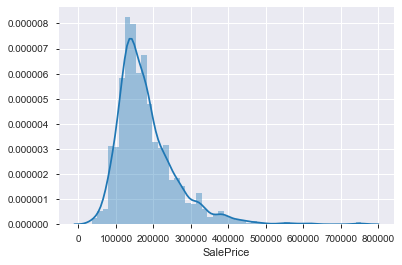

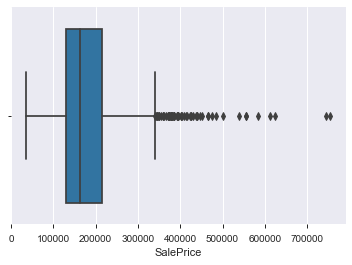

skew:  1.8828757597682129
skew:  6.536281860064529


In [4]:
#The plot below shows that SalePrice is not normally distributed and has a right skew.

sns.distplot(train['SalePrice'])
plt.show();
#Boxplot of SalePrice
sns.boxplot('SalePrice', data=train, whis = 1.5)
plt.show();

#skew and kurtosis
print("skew: ",train['SalePrice'].skew())
print("skew: ",train['SalePrice'].kurt())

# Data Preprocessing

In [5]:
#missing data
nulls = train.isnull().sum().sort_values(ascending = False)
perc_null = (train.isnull().sum() / train.isnull().count()).sort_values(ascending = False)
null_data = pd.concat([nulls, perc_null], axis = 1, keys = ['Nulls', '% Nulls'])
null_data.head(10)

Nulls   % Nulls
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageCond       81  0.055479
GarageType       81  0.055479
GarageYrBlt      81  0.055479
GarageFinish     81  0.055479

In [6]:
#missing data in test
num_null = test.isnull().sum().sort_values(ascending = False)
perc_null = (test.isnull().sum() / test.isnull().count()).sort_values(ascending = False)
null_data = pd.concat([num_null, perc_null], axis = 1, keys = ['Nulls', '% Nulls'])
null_data.head(10)


Nulls   % Nulls
PoolQC         1456  0.997944
MiscFeature    1408  0.965045
Alley          1352  0.926662
Fence          1169  0.801234
FireplaceQu     730  0.500343
LotFrontage     227  0.155586
GarageCond       78  0.053461
GarageQual       78  0.053461
GarageYrBlt      78  0.053461
GarageFinish     78  0.053461

In [7]:
#To separate numerical features out so that we can analyze the data comparatively

print('Numerical Features: ',end='')
print(len(train.select_dtypes(include=['number', 'int32','int64','float64']).columns.values))

numerical = train.select_dtypes(include=['number', 'int32','int64','float64']).columns
num_df = train[numerical]

numericaltest = test.select_dtypes(include=['number', 'int32','int64','float64']).columns
numtest_df = test[numericaltest]


Numerical Features: 38


In [76]:
numerical

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'TotalSF',
       'SalePriceStdScale', 'Bath', 'HouseAge', 'SalePriceLog'],
      dtype='object')

In [8]:
#Feature Creation and more preproccessing
#included a new column "Total Square Footage", which is basement total sf + 1st floor + 2nd floor

train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

standard_scale = StandardScaler()
train['SalePriceStdScale'] = standard_scale.fit_transform(train[['SalePrice']])

#feature creation - combining baths into one feature for improved cleanliness and inference    
train['Bath'] = train['FullBath'] + train['HalfBath']
test['Bath'] = test['FullBath'] + test['HalfBath']

train['HouseAge'] = train['YrSold']-train['YearBuilt']
test['HouseAge'] = test['YrSold']-test['YearBuilt']

#dropped redundant features as well as nulls exceeding 80% of the dataset
train.drop(columns = ['FullBath','HalfBath','Id','TotalBsmtSF', '1stFlrSF', '2ndFlrSF'\
                     , 'PoolQC', 'MiscFeature','Alley','Fence'])

test.drop(columns = ['FullBath','HalfBath','Id','TotalBsmtSF', '1stFlrSF', '2ndFlrSF'\
                     , 'PoolQC', 'MiscFeature','Alley','Fence'])

# replace 'NaN' with '0' in all columns
train.fillna(0, inplace = True)
test.fillna(0, inplace = True)
train.head(20)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0    1          60       RL         65.0     8450   Pave     0      Reg   
1    2          20       RL         80.0     9600   Pave     0      Reg   
2    3          60       RL         68.0    11250   Pave     0      IR1   
3    4          70       RL         60.0     9550   Pave     0      IR1   
4    5          60       RL         84.0    14260   Pave     0      IR1   
5    6          50       RL         85.0    14115   Pave     0      IR1   
6    7          20       RL         75.0    10084   Pave     0      Reg   
7    8          60       RL          0.0    10382   Pave     0      IR1   
8    9          50       RM         51.0     6120   Pave     0      Reg   
9   10         190       RL         50.0     7420   Pave     0      Reg   
10  11          20       RL         70.0    11200   Pave     0      Reg   
11  12          60       RL         85.0    11924   Pave     0      IR1   
12  13          20       RL          0.0    12968   Pave     0      IR2   
13  14          20       RL         91.0    10652   Pave     0      IR1   
14  15          20       RL          0.0    10920   Pave     0      IR1   
15  16          45       RM         51.0     6120   Pave     0      Reg   
16  17          20       RL          0.0    11241   Pave     0      IR1   
17  18          90       RL         72.0    10791   Pave     0      Reg   
18  19          20       RL         66.0    13695   Pave     0      Reg   
19  20          20       RL         70.0     7560   Pave     0      Reg   

   LandContour Utilities  ... MiscVal MoSold YrSold SaleType SaleCondition  \
0          Lvl    AllPub  ...       0      2   2008       WD        Normal   
1          Lvl    AllPub  ...       0      5   2007       WD        Normal   
2          Lvl    AllPub  ...       0      9   2008       WD        Normal   
3          Lvl    AllPub  ...       0      2   2006       WD       Abnorml   
4          Lvl    AllPub  ...       0     12   2008       WD        Normal   
5          Lvl    AllPub  ...     700     10   2009       WD        Normal   
6          Lvl    AllPub  ...       0      8   2007       WD        Normal   
7          Lvl    AllPub  ...     350     11   2009       WD        Normal   
8          Lvl    AllPub  ...       0      4   2008       WD       Abnorml   
9          Lvl    AllPub  ...       0      1   2008       WD        Normal   
10         Lvl    AllPub  ...       0      2   2008       WD        Normal   
11         Lvl    AllPub  ...       0      7   2006      New       Partial   
12         Lvl    AllPub  ...       0      9   2008       WD        Normal   
13         Lvl    AllPub  ...       0      8   2007      New       Partial   
14         Lvl    AllPub  ...       0      5   2008       WD        Normal   
15         Lvl    AllPub  ...       0      7   2007       WD        Normal   
16         Lvl    AllPub  ...     700      3   2010       WD        Normal   
17         Lvl    AllPub  ...     500     10   2006       WD        Normal   
18         Lvl    AllPub  ...       0      6   2008       WD        Normal   
19         Lvl    AllPub  ...       0      5   2009      COD       Abnorml   

   SalePrice TotalSF  SalePriceStdScale  Bath  HouseAge  
0     208500    2566           0.347273     3         5  
1     181500    2524           0.007288     2        31  
2     223500    2706           0.536154     3         7  
3     140000    2473          -0.515281     1        91  
4     250000    3343           0.869843     3         8  
5     143000    2158          -0.477505     2        16  
6     307000    3380           1.587588     2         3  
7     200000    3197           0.240241     3        36  
8     129900    2726          -0.642461     2        77  
9     118000    2068          -0.792306     1        69  
10    129500    2080          -0.647497     1        43  
11    345000    3499           2.066086     3         1  
12    144000    1824          -0.46

# Exploratory Data Analysis

(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <a list of 10 Patch objects>)

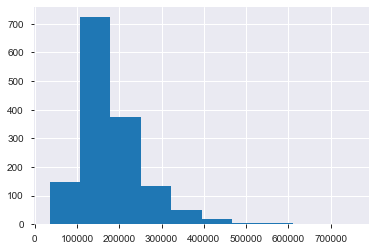

In [9]:
#To plot a histogram of all Sales Prices
plt.hist(train['SalePrice'])

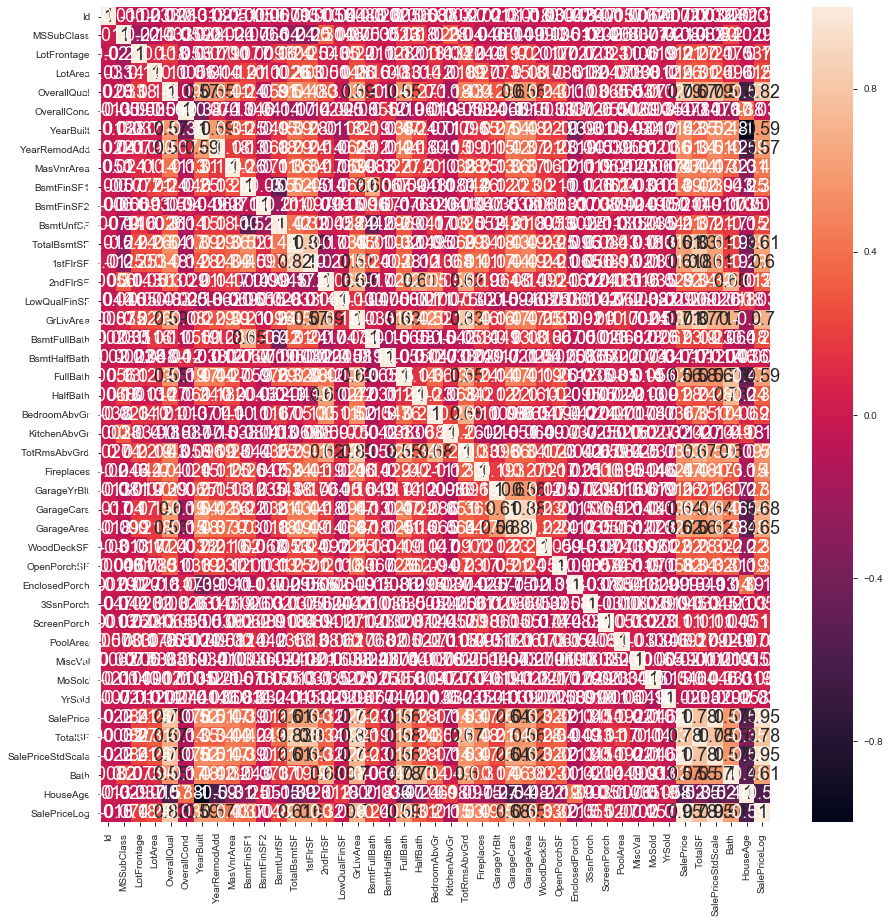

In [72]:
#To find relationships in the entire dataset, we create a correlation heatmap.

corrmat = num_df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corrmat,annot=True)
plt.show()

In [11]:
#From the heatmap above, we obtain the 5 strongest predictors of saleprice
num_strong_corr = corrmat.nlargest(17, 'SalePrice')['SalePrice'].index
num_strong_corr

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1',
       'LotFrontage', 'WoodDeckSF'],
      dtype='object')

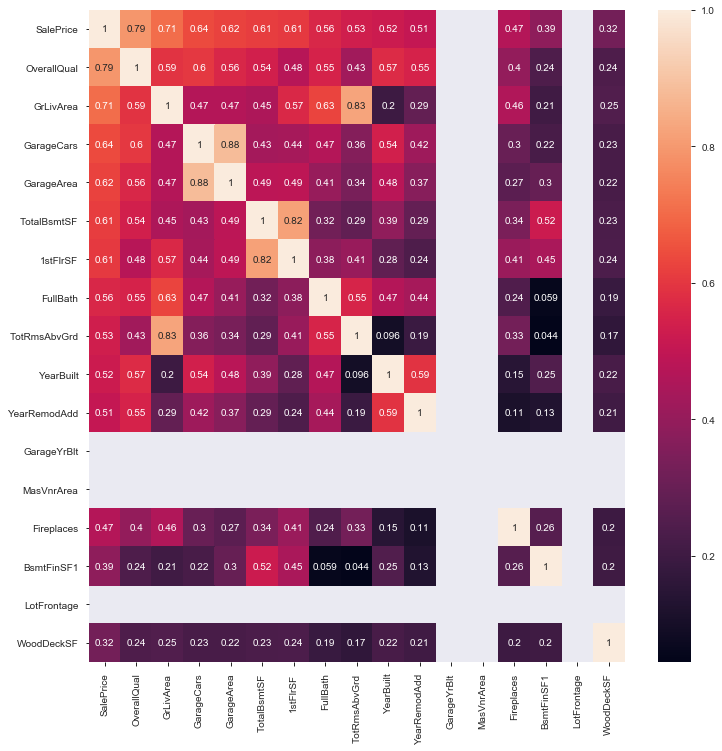

In [12]:
#We create a new correlation heatmap to look at those only
num_corrmat = np.corrcoef(num_df[num_strong_corr].values.T)
fix, ax = plt.subplots(figsize=(12,12))
sns.heatmap(num_corrmat, annot=True, xticklabels = num_strong_corr.values, yticklabels = num_strong_corr.values)

C:\Users\chris\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\chris\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


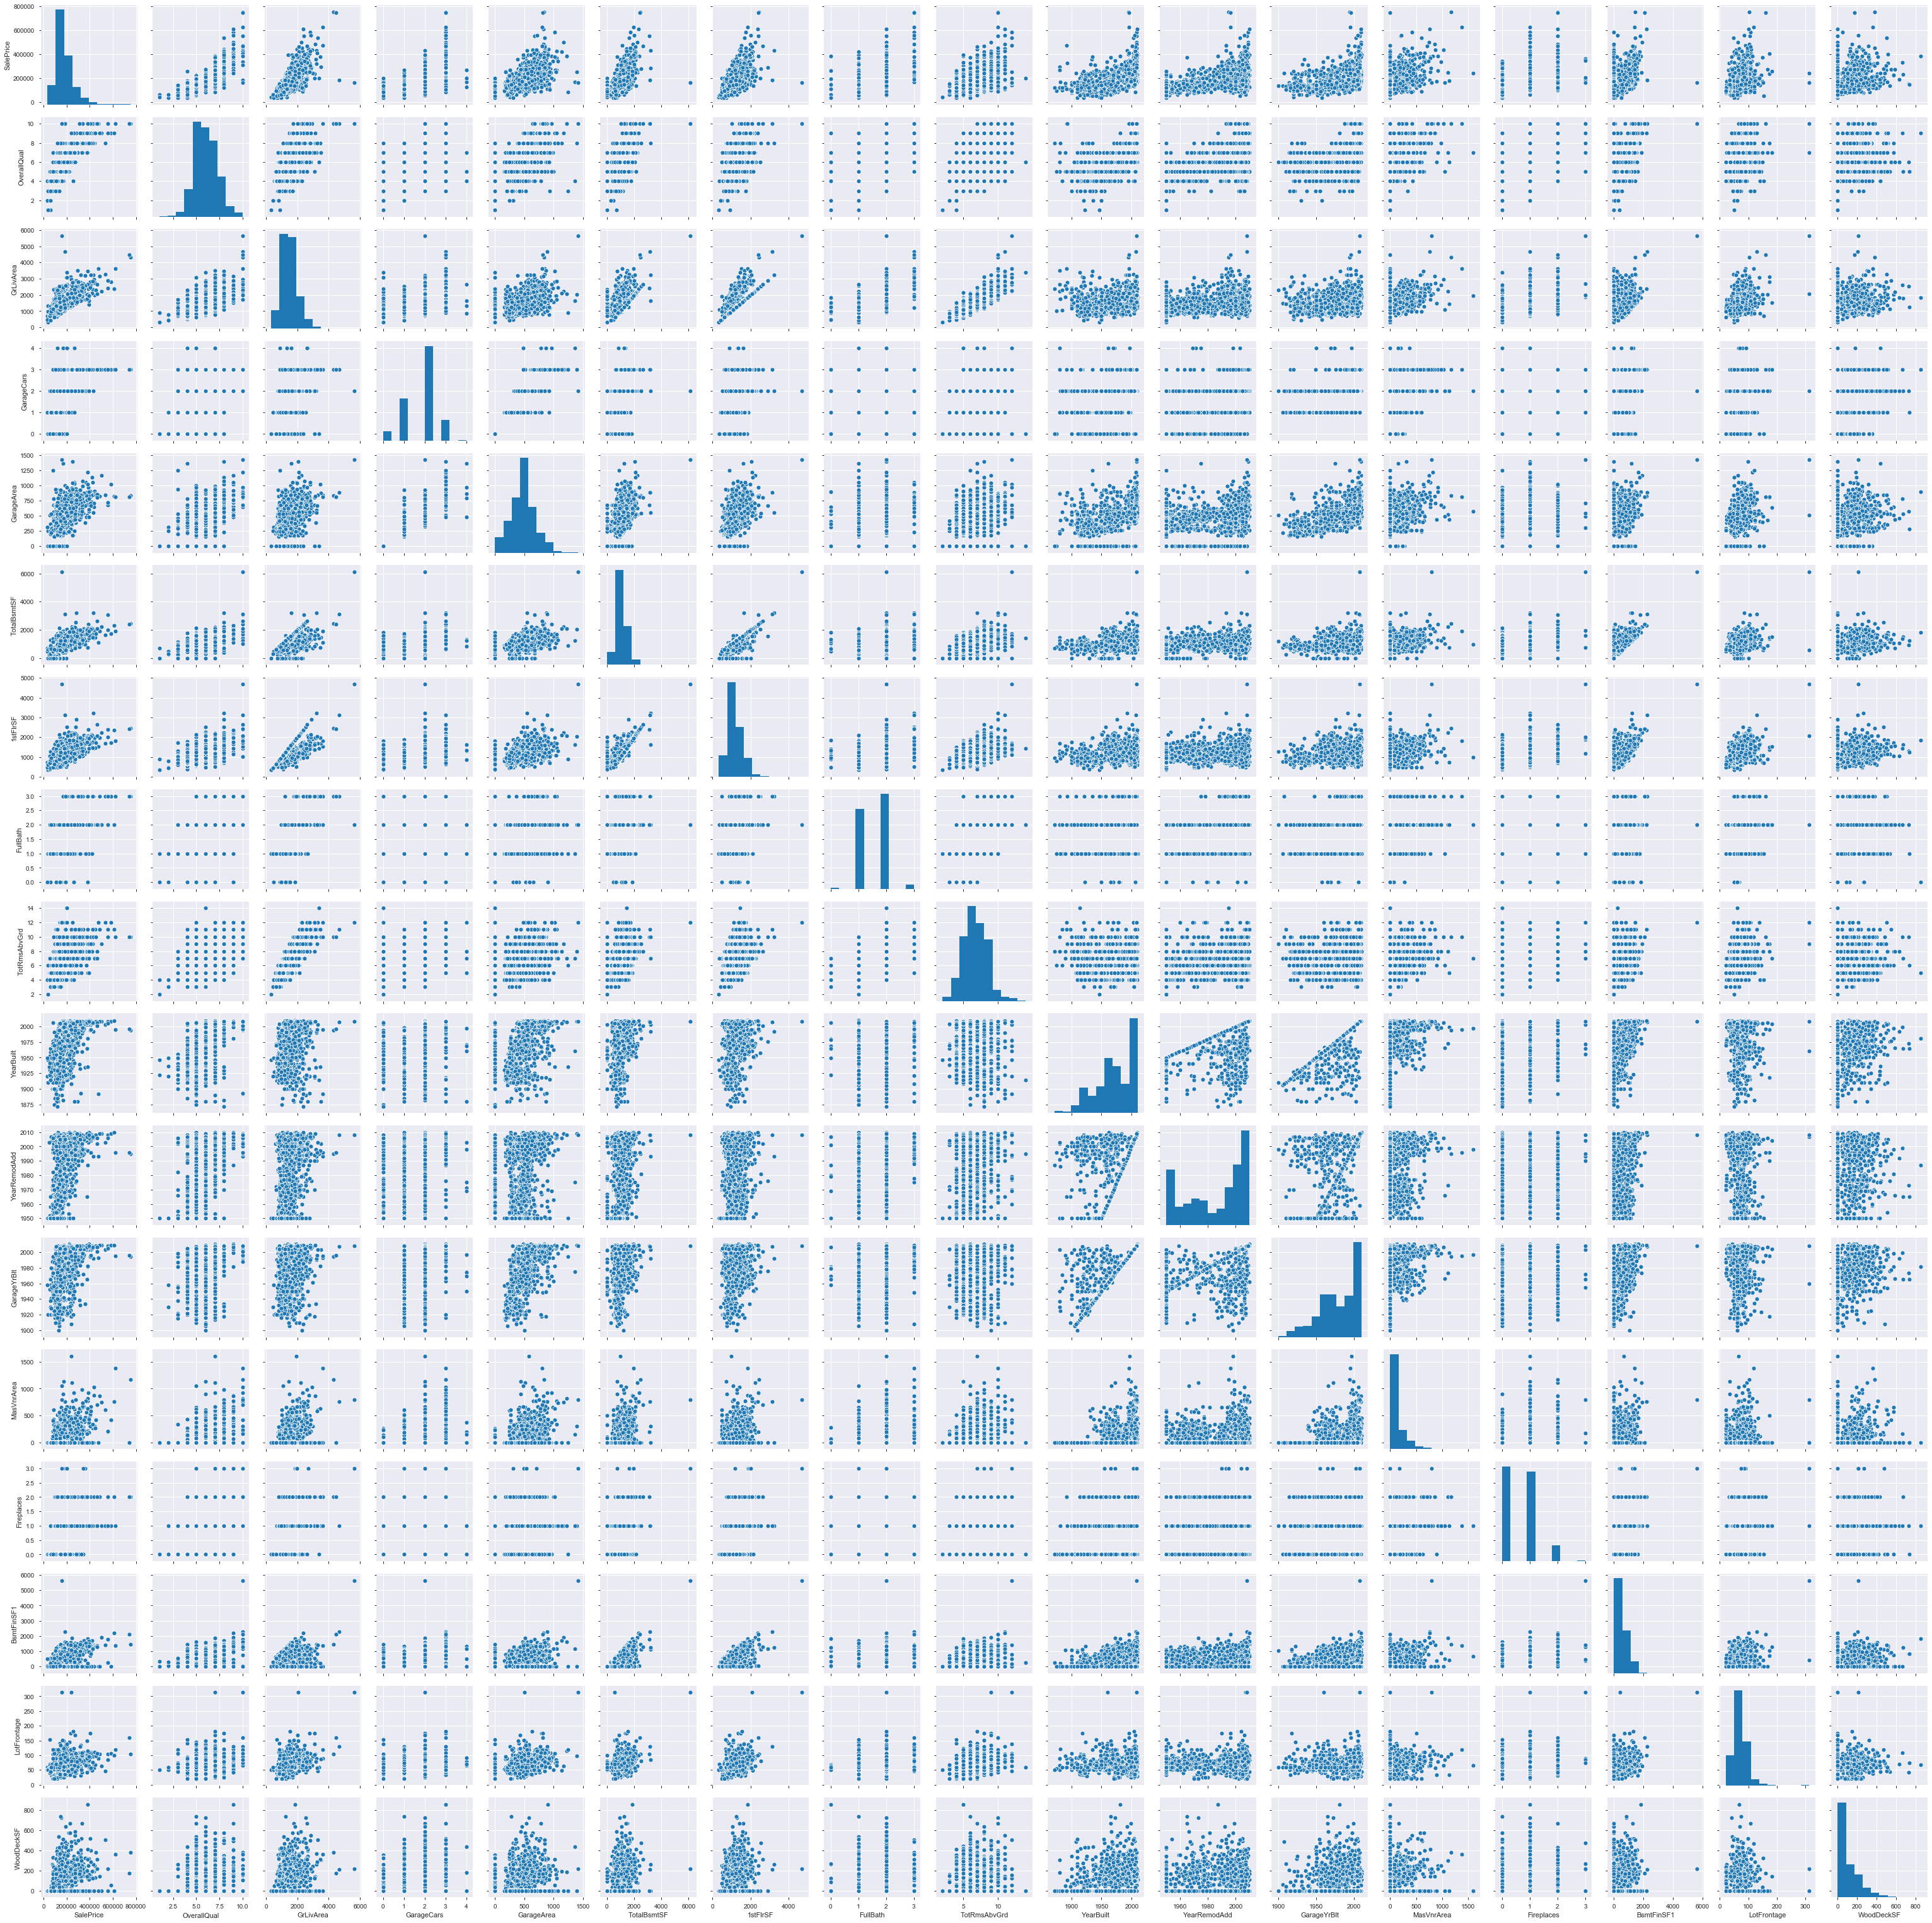

In [13]:
sns.pairplot(num_df[num_strong_corr])
plt.show()

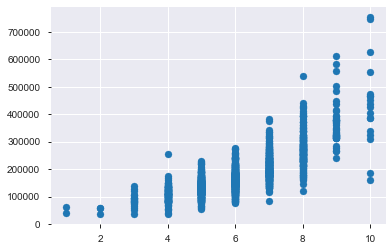

In [14]:
#plotting Overall Quality ratings to sale price shows the strongest correlation to sale price

plt.scatter(train['OverallQual'], train['SalePrice'])


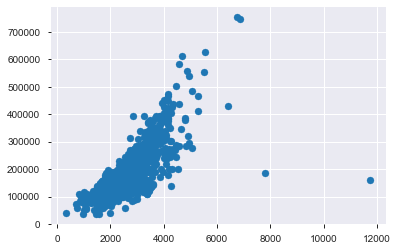

In [15]:
#plotting total square footage to sale price shows a strong correlation

plt.scatter(train['TotalSF'], train['SalePrice'])


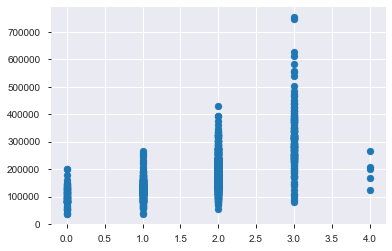

In [16]:
#Garage cars also has a fairly strong correlation, however it seems to drop off at 4 car garages
plt.scatter(train['GarageCars'], train['SalePrice'])

In [70]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave     0      Reg   
1   2          20       RL         80.0     9600   Pave     0      Reg   
2   3          60       RL         68.0    11250   Pave     0      IR1   
3   4          70       RL         60.0     9550   Pave     0      IR1   
4   5          60       RL         84.0    14260   Pave     0      IR1   

  LandContour Utilities  ... MoSold YrSold SaleType SaleCondition SalePrice  \
0         Lvl    AllPub  ...      2   2008       WD        Normal    208500   
1         Lvl    AllPub  ...      5   2007       WD        Normal    181500   
2         Lvl    AllPub  ...      9   2008       WD        Normal    223500   
3         Lvl    AllPub  ...      2   2006       WD       Abnorml    140000   
4         Lvl    AllPub  ...     12   2008       WD        Normal    250000   

  TotalSF SalePriceStdScale  Bath  HouseAge  SalePriceLog  
0    2566          0.347273     3         5     12.247699  
1    2524          0.007288     2        31     12.109016  
2    2706          0.536154     3         7     12.317171  
3    2473         -0.515281     1        91     11.849405  
4    3343          0.869843     3         8     12.429220  

[5 rows x 86 columns]

# Categorical Features Analysis:

Categorical features: 43


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this war

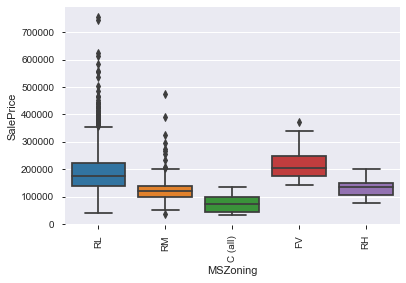

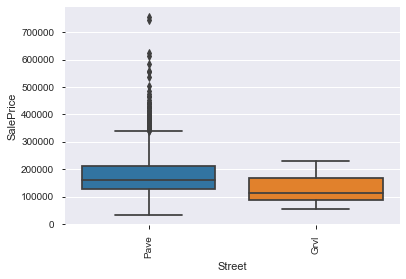

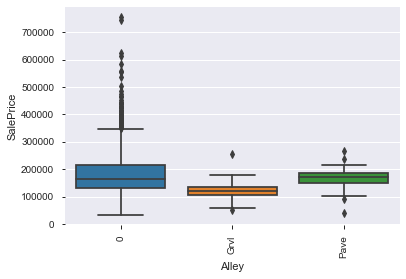

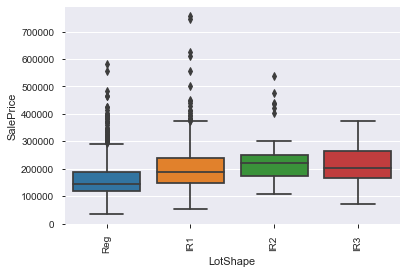

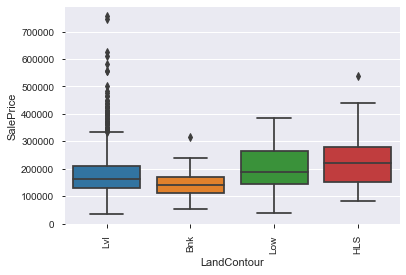

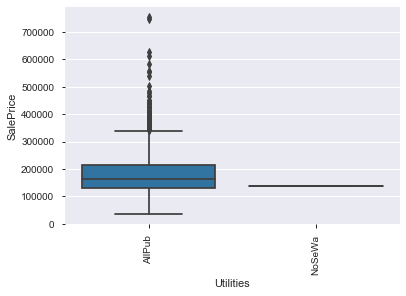

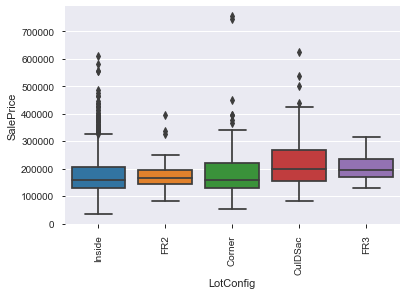

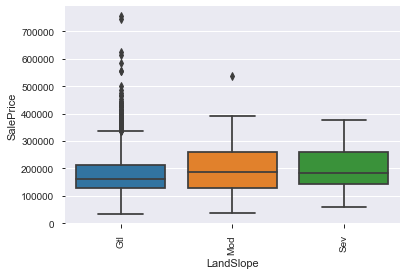

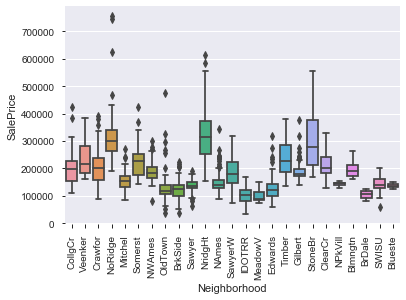

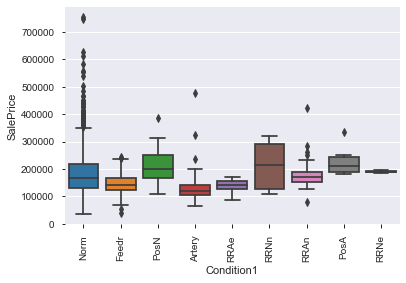

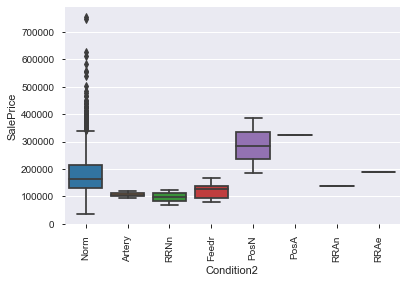

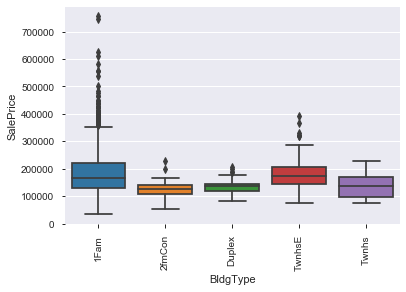

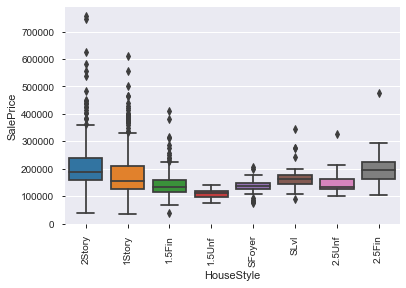

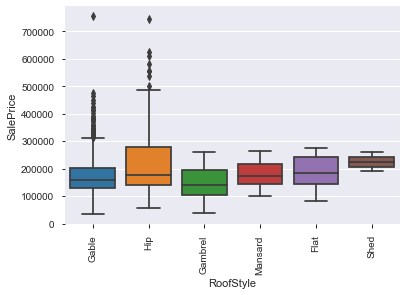

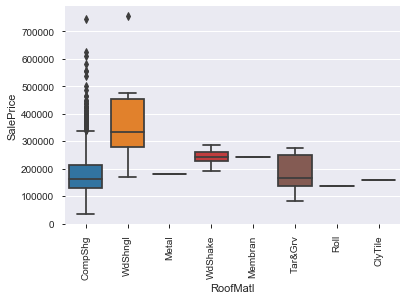

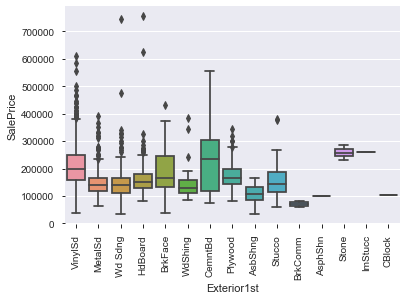

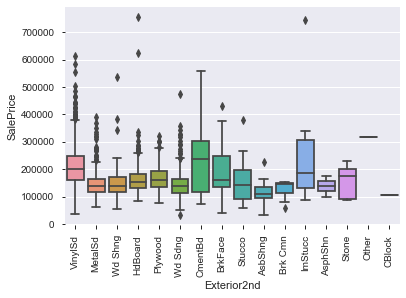

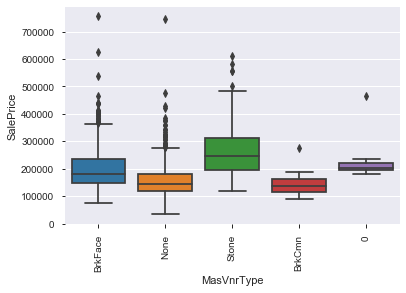

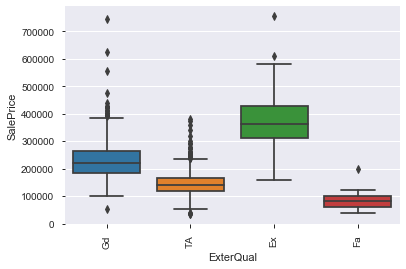

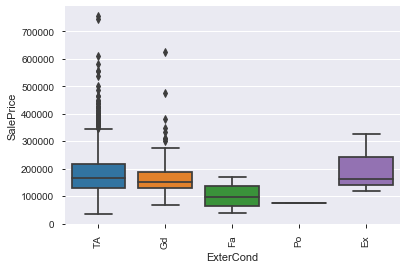

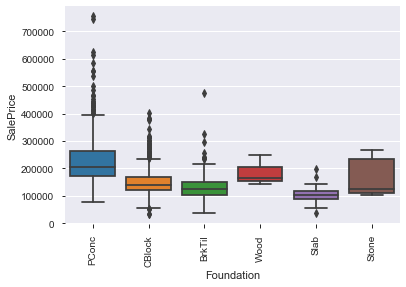

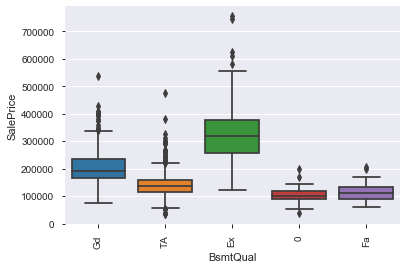

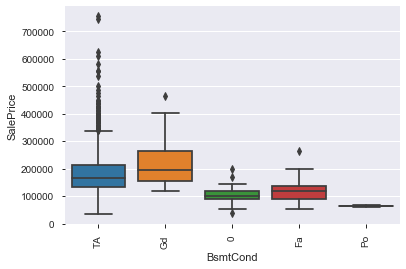

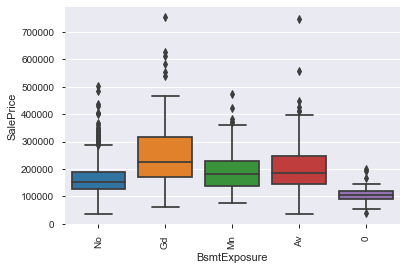

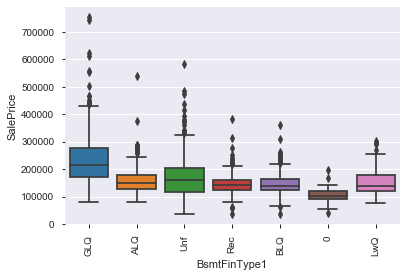

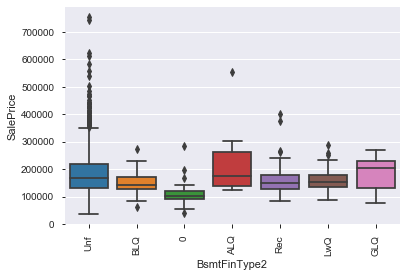

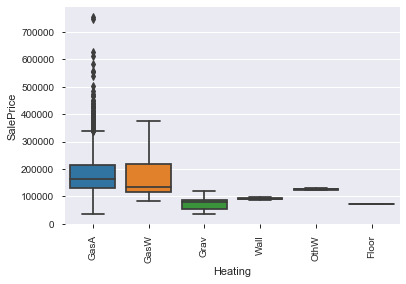

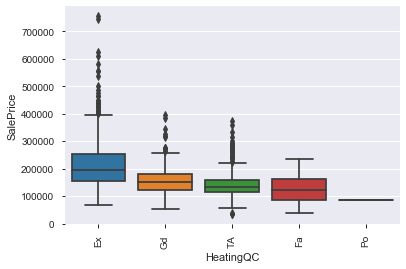

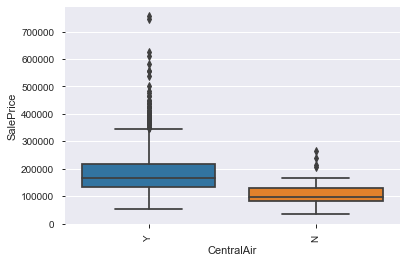

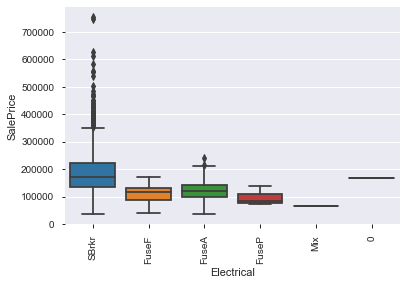

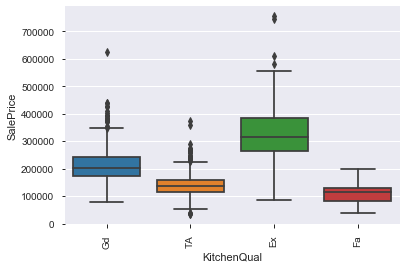

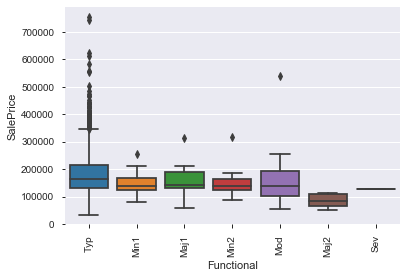

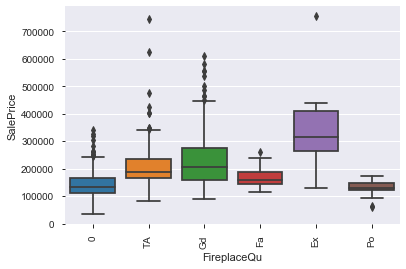

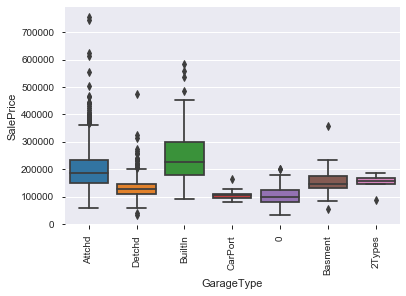

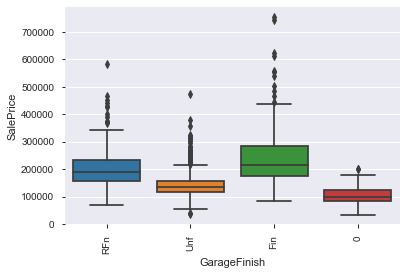

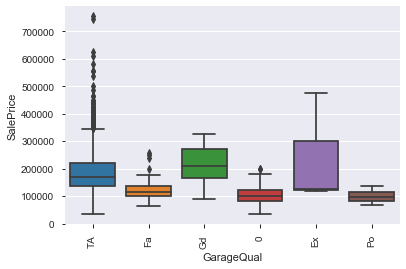

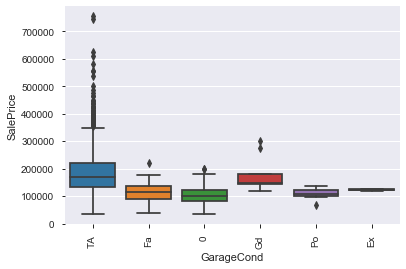

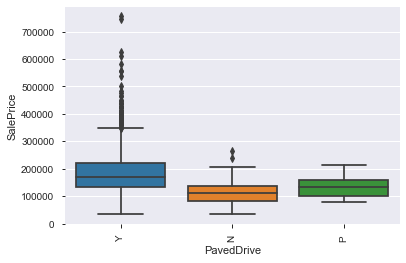

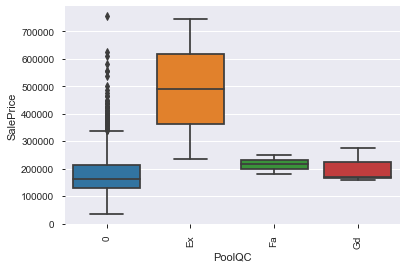

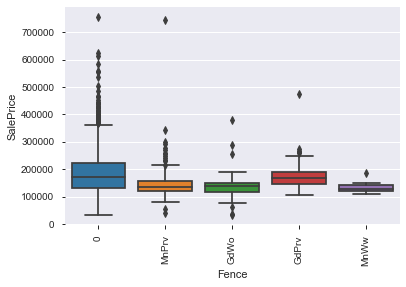

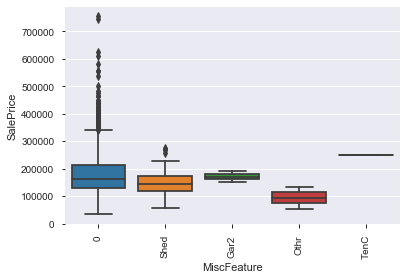

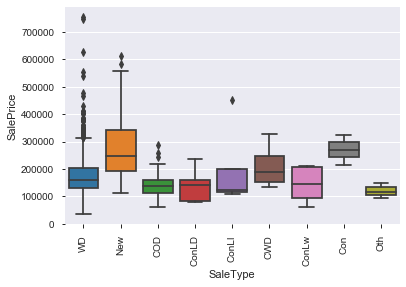

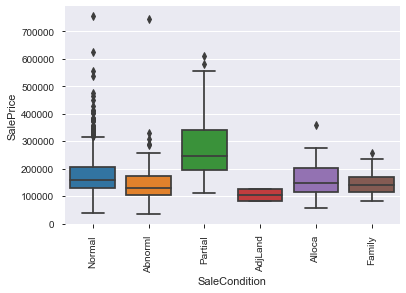

In [17]:
#first creating a new dataframe with only categorical features, and then
#using for loop to iterate over each column to create a box plot for each relation to SalePrice

print('Categorical features: ', end= '')
print(len(train.select_dtypes(include=['O']).columns.values))

categorical = train.select_dtypes(include='object').columns
categorical

categoricaltest = test.select_dtypes(include='object').columns

for column in categorical:
    fig, ax = plt.subplots()
    plt.xticks(rotation = 90)
    sns.boxplot(y='SalePrice', data = train, x = column)
plt.show()

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot inte

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot inte

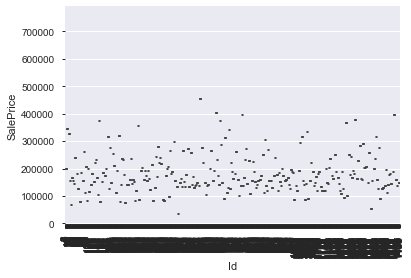

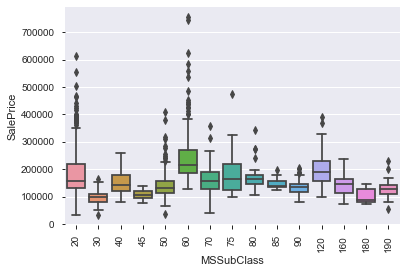

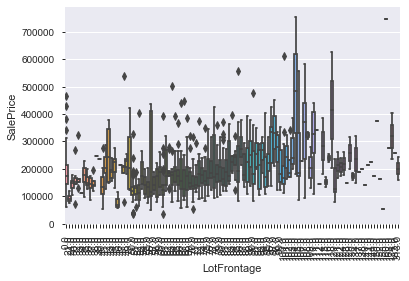

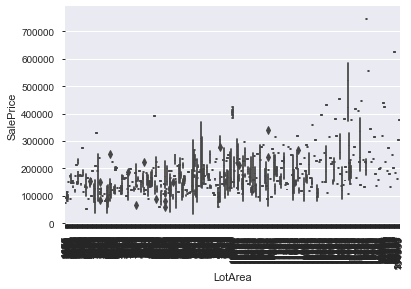

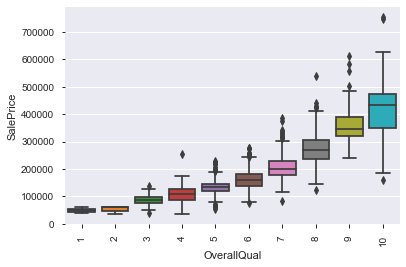

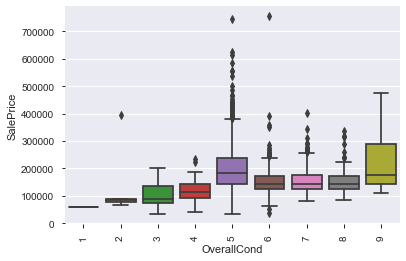

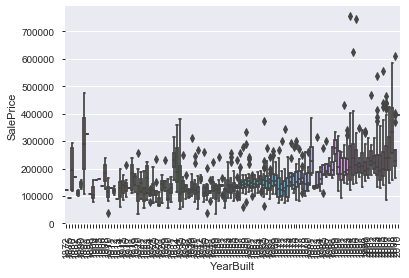

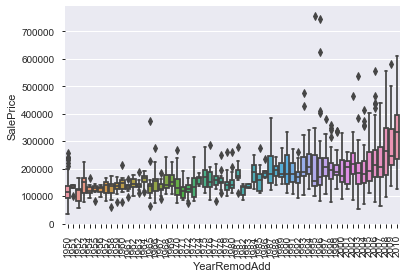

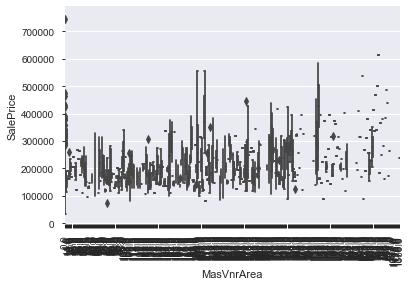

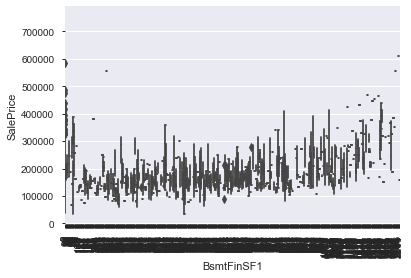

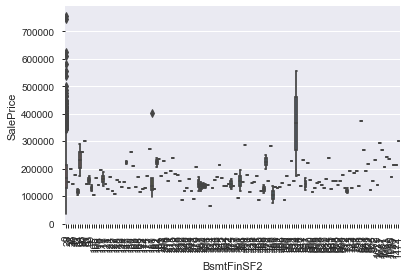

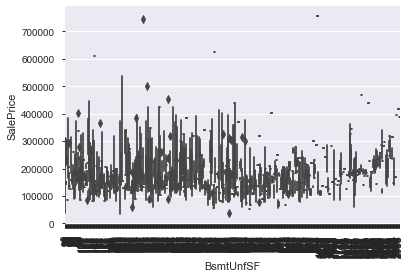

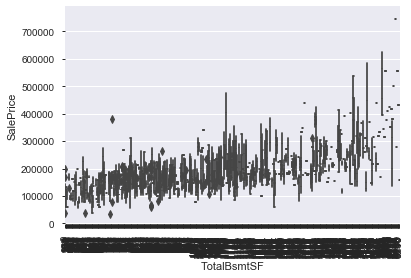

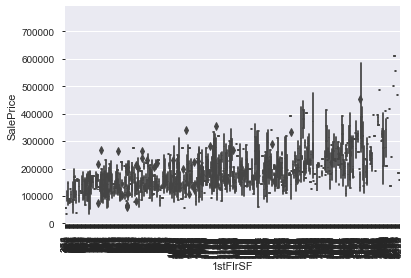

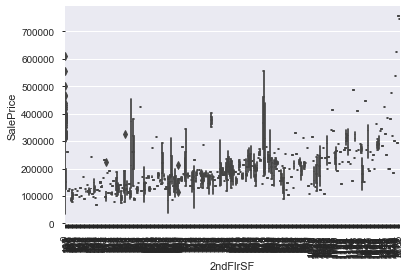

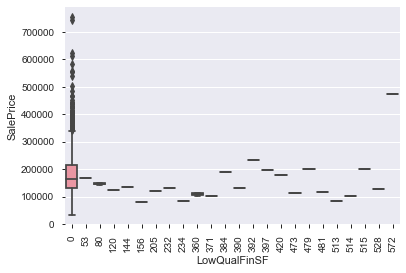

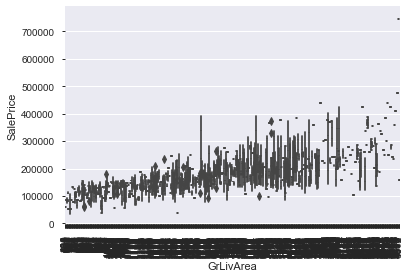

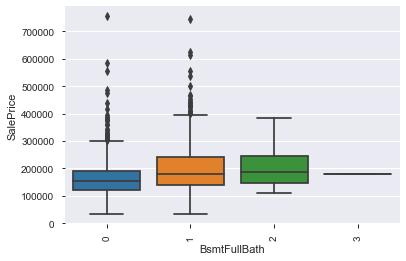

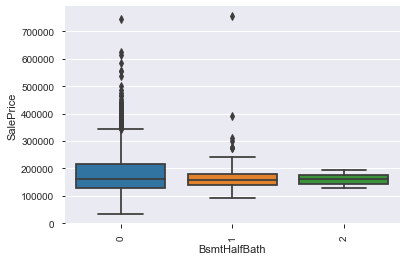

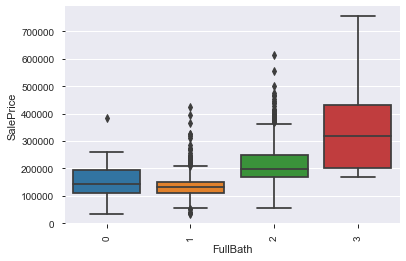

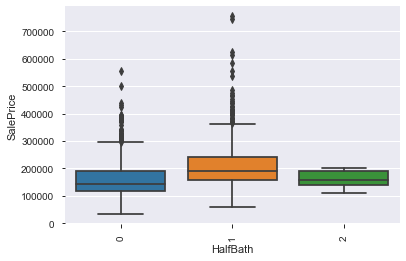

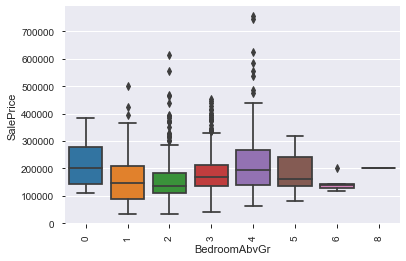

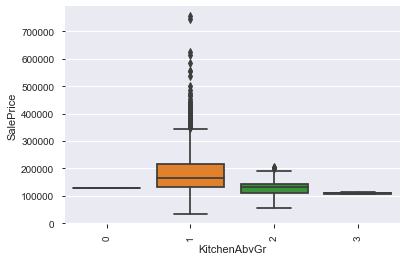

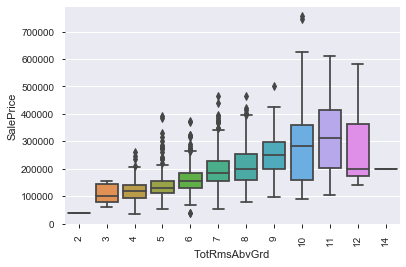

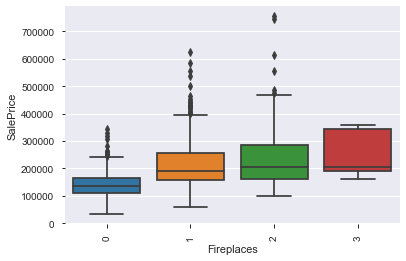

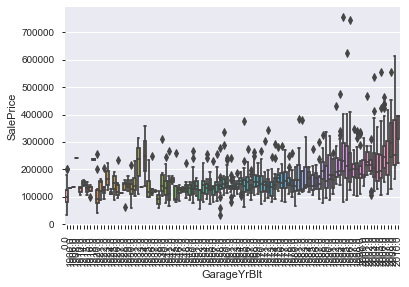

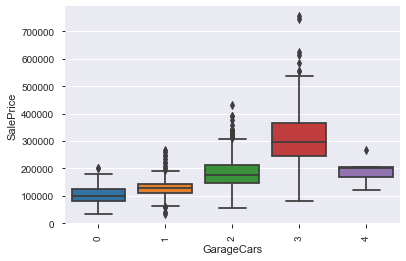

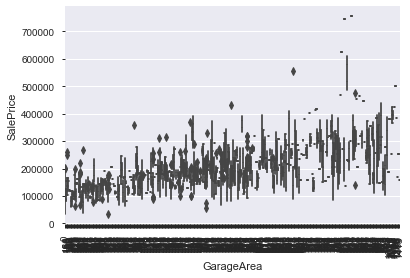

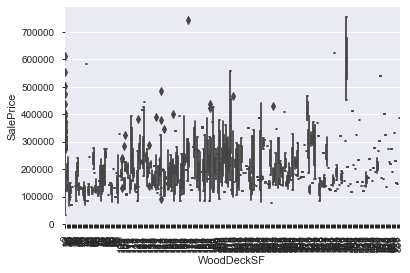

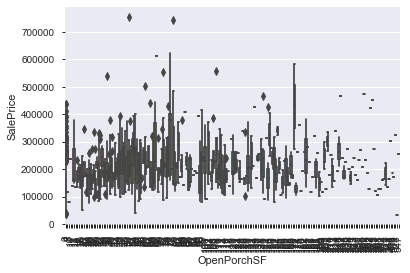

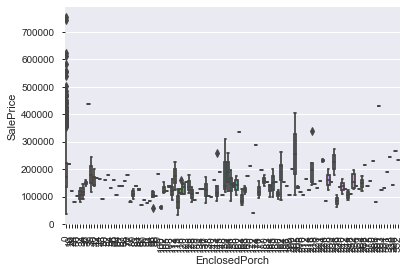

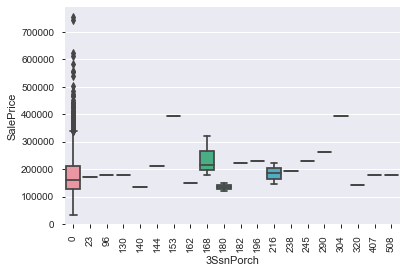

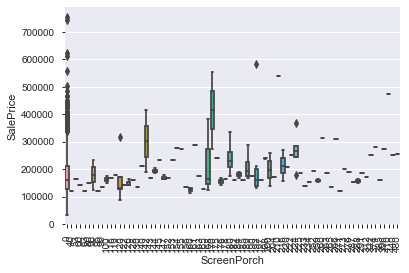

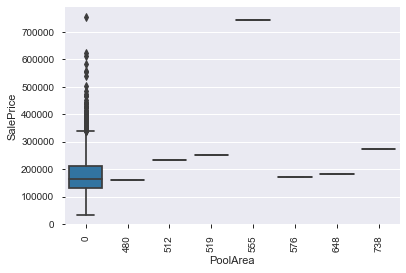

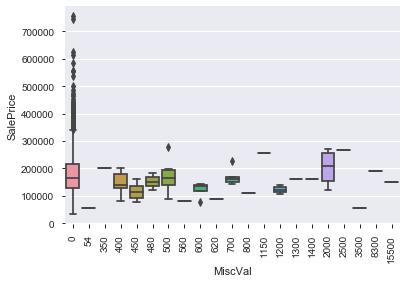

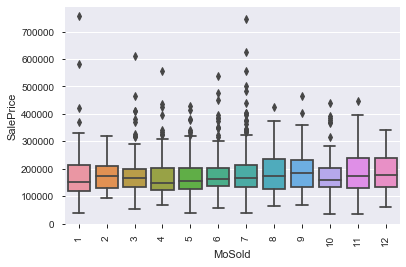

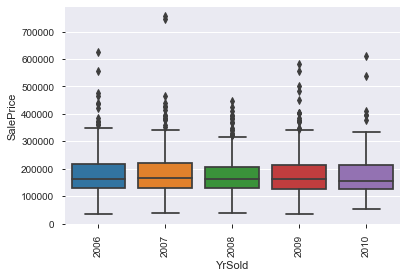

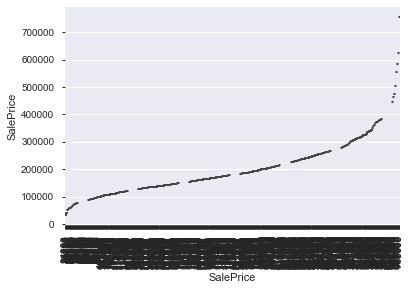

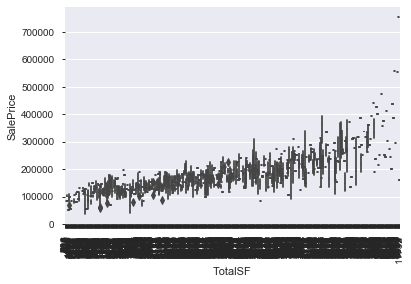

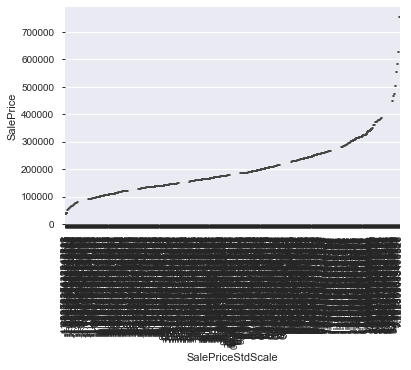

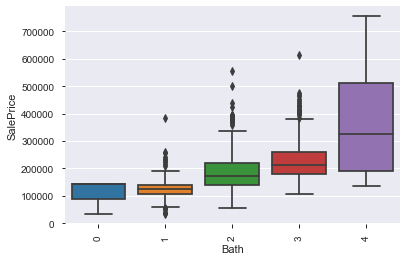

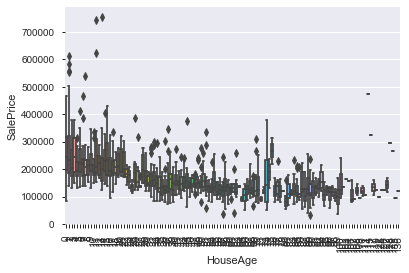

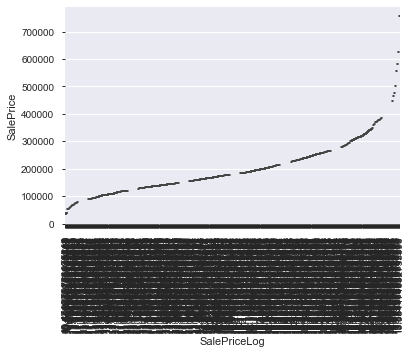

In [75]:
###
for column in numerical:
    fig, ax = plt.subplots()
    plt.xticks(rotation = 90)
    sns.boxplot(y='SalePrice', data = train, x = column)
plt.show()

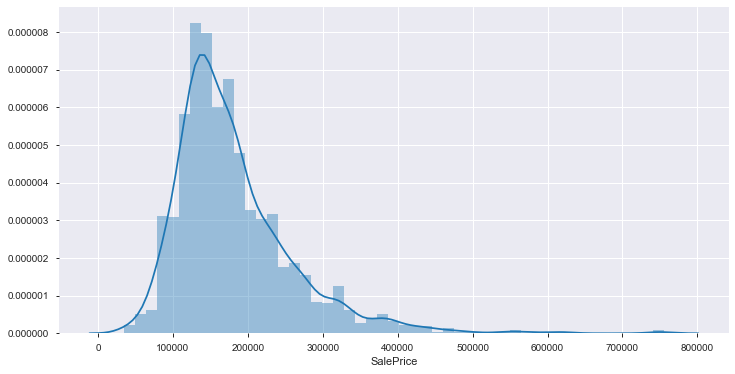

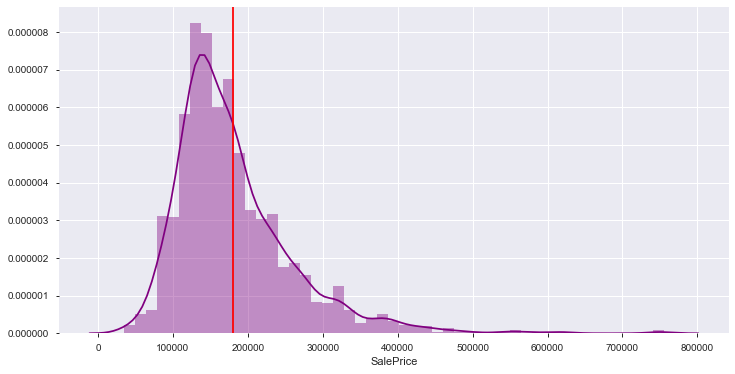

In [18]:
#To normalize the distribution for linear regression

from scipy.stats import norm
plt.figure(figsize=(12,6))
sns.distplot(train['SalePrice'])
plt.figure(figsize=(12,6))
sns.distplot(train['SalePrice'],color='purple')
plt.axvline(x=(train['SalePrice'].mean()), color='r')

train['SalePriceLog'] = np.log1p(train['SalePrice'])

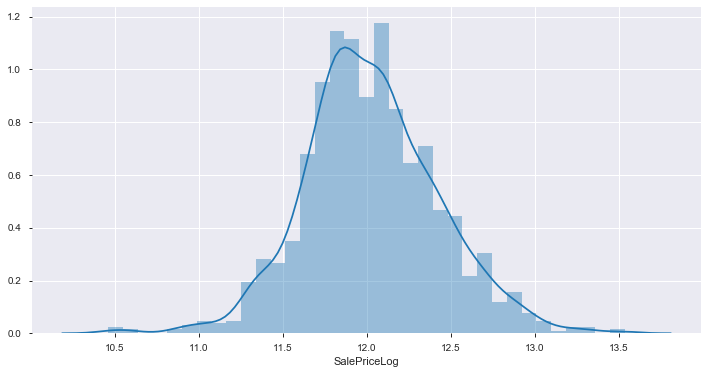

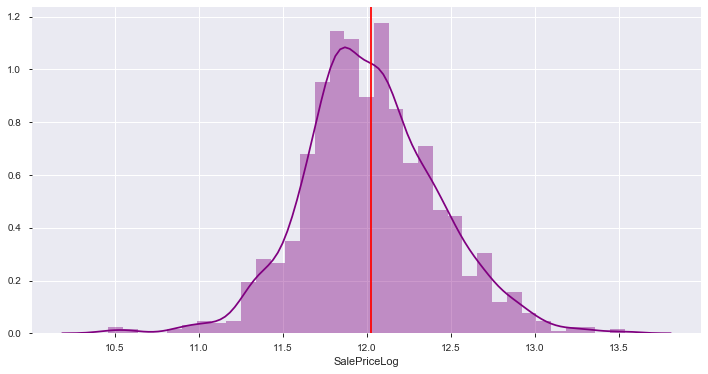

In [19]:
plt.figure(figsize=(12,6))
sns.distplot(train['SalePriceLog'])
plt.figure(figsize=(12,6))
sns.distplot(train['SalePriceLog'],color='purple')
plt.axvline(x=(train['SalePriceLog'].mean()), color='r')

# Regression Data Creation - Train and Test Set and Variables

In [20]:
#To separate numerical features out so that we can analyze the data comparatively

print('Numerical Features: ',end='')
print(len(train.select_dtypes(include=['number', 'int32','int64','float64']).columns.values))

numerical = train.select_dtypes(include=['number', 'int32','int64','float64']).columns
num_df = train[numerical]

numericaltest = test.select_dtypes(include=['number', 'int32','int64','float64']).columns
numtest_df = test[numericaltest]


# Create a dataframe for numerical and categorical variables for both training and test set
#cat_df = train[categorical]
#cattest_df = test[categoricaltest]
#num_df = train[numerical]
#numtest_df = test[numericaltest]

#pick out your prediction variables
traincat1=train[['Neighborhood','SaleCondition']]
trainnum1=train[['OverallQual', 'TotalSF','GarageCars','YearBuilt','YearRemodAdd','YrSold','HouseAge']]

testcat1=test[['Neighborhood','SaleCondition']]
testnum1=test[['OverallQual', 'TotalSF','GarageCars','YearBuilt','YearRemodAdd','YrSold','HouseAge']]


# create dataframe of dummy variables
catdummies1 = pd.get_dummies(traincat1, drop_first = True)
catdummiestest1 = pd.get_dummies(testcat1, drop_first = True)

# Merge numerical and categorical to one dataframe
finaltrain = pd.concat([catdummies1, trainnum1], axis=1)

#for use on unseen test data
finaltestunseen = pd.concat([catdummiestest1, testnum1], axis=1)

#define input variable (x) and ouput variable y

X=finaltrain
y=train['SalePrice']

Numerical Features: 43


In [21]:
#Test data for Kaggle submission should mirror the training set
finaltestunseen.head()

finaltrain.shape

(1460, 36)

In [22]:
finaltestunseen.shape

(1459, 36)

In [23]:
# Train Test Split = split x and y into X_
# Partition the dataset in train + validation sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .50, random_state = 100) # use 50% as the testing data
#and 50% will be defaulted to the training data

from sklearn import metrics
from sklearn.model_selection import cross_val_score

# Metrics and Scatterplot Functions (Residuals, Actual vs Predictions

In [24]:
def modelmetrics(actual, predicted):  
    mae = metrics.mean_absolute_error(actual, predicted)
    mse = metrics.mean_squared_error(actual, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(actual, predicted))
    r2_square = metrics.r2_score(actual, predicted)
    print('Mean Average Error:', mae)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('R2 Square:', r2_square)

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def residuals_plot(y_train_model, y_train, y_test_model,y_test):
    plt.scatter(y_train_model, y_train_model - y_train, c = "blue", marker = "s", label = "Training data")
    plt.scatter(y_test_model, y_test_model - y_test, c = "lightgreen", marker = "s", label = "Validation data")
    plt.title("Residuals vs Predicted Values Plot")
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.legend(loc = "upper left")
    plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
    plt.show()
    
def predictions_plot(y_train_model, y_train, y_test_model, y_test):
    plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
    plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
    plt.title("Predictions vs Actuals")
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.legend(loc = "upper left")
    plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
    plt.show()
    
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)


# Linear Regression

In [25]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

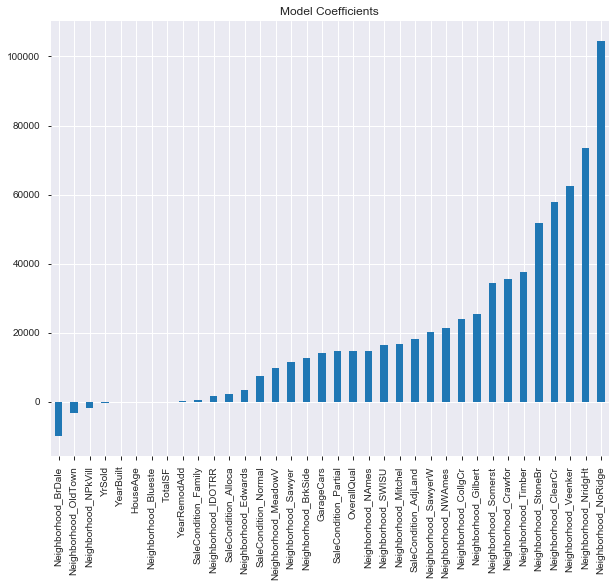

In [26]:
#plotting the coefficients for each feature inspected, appears overall quality and garage cars
#have the highest impact to sale price, initially thought total square footage had a higher
#impact

from pandas import Series, DataFrame
predictors = X_train.columns
 
coef = Series(lin_reg.coef_.flatten(), predictors).sort_values()
plt.figure(figsize=(10,8))
 
coef.plot(kind='bar', title='Model Coefficients')
plt.show()

In [27]:
#predicting sale price values from X for Kaggle submission unseen test set
y_predictlintest = lin_reg.predict(finaltestunseen)
y_predictlintest[:10] #predict the first 10 values)

array([111893.74297085, 153604.94874268, 170189.26941907, 184021.11155397,
       239386.62053113, 179542.91694739, 181240.23980224, 175323.53962533,
       200269.51220707, 112915.44553451])

In [28]:
#predicting sale values on the remaining test set
y_predictlin = lin_reg.predict(X_test)
y_predictlin[:10] #predict the first 10 values)

array([113673.58948124, 202487.07865361, 198667.75793701, 207345.92563836,
       147357.02738839, 198602.65635492, 206166.40554439, 257571.45434143,
        95041.31585785, 174020.47342718])

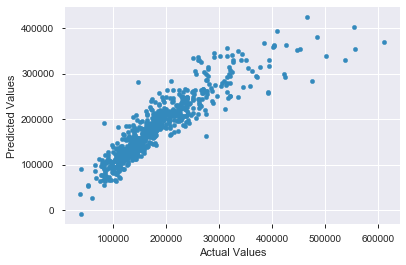

In [29]:
#testing our model's accuracy of its predicted values to its true values on scatter plot
#using our top 5 features: 'OverallQual', 'TotalSF','GarageCars','YearBuilt','YearRemodAdd'
pd.DataFrame({'Actual Values': y_test, 'Predicted Values': y_predictlin}).plot.scatter\
(x='Actual Values', y='Predicted Values')



In [30]:
test_pred_lin = lin_reg.predict(X_test)
train_pred_lin = lin_reg.predict(X_train)

print('Train Set Linear Regression: \n')
modelmetrics(y_test, train_pred_lin)

print('\nTest set Linear Regression: \n')
modelmetrics(y_test, test_pred_lin)
print("Cross Validation", cross_val(LinearRegression()))


Train Set Linear Regression: 

Mean Average Error: 79229.93645833487
Mean Squared Error: 11585941267.304226
Root Mean Squared Error: 107638.01032769152
R2 Square: -0.8895731087027845

Test set Linear Regression: 

Mean Average Error: 21203.626928092162
Mean Squared Error: 1122497387.355197
Root Mean Squared Error: 33503.69214512331
R2 Square: 0.8169297747330089
Cross Validation 0.8010257522231827


Text(0.5, 0, 'y_test')

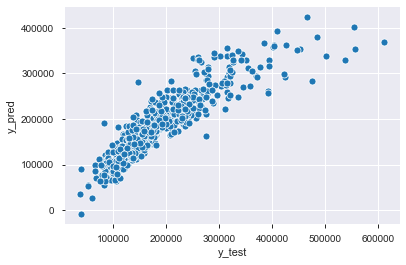

In [31]:
#to test residuals of the linear regression
test_residual = y_test-y_predictlin
sns.scatterplot(x=y_test, y=y_predictlin)
plt.ylabel('y_pred')
plt.xlabel('y_test')

In [32]:
modeltest = pd.Series(lin_reg.predict(finaltestunseen), name = 'SalePrice')

modelsubmission = pd.concat([test['Id'], modeltest], axis=1)

modelsubmission.to_csv('linearsubmissionCL.csv', index = False)

# Best Subset Selection

In [33]:
#tribute to http://www.science.smith.edu/~jcrouser/SDS293/labs/lab8-py.html for this coding
import itertools
import time
import statsmodels.api as sm

In [34]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,trainnum1[list(feature_set)]) #change the x variables as needed
    regr = model.fit()
    RSS = ((regr.predict(trainnum1[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [35]:
list(trainnum1.columns)

['OverallQual',
 'TotalSF',
 'GarageCars',
 'YearBuilt',
 'YearRemodAdd',
 'YrSold',
 'HouseAge']

In [36]:
def getBest(k):
    
    tic = time.time() #start of processing time
    
    results = []
    
    for combo in itertools.combinations(trainnum1.columns, k):
        results.append(processSubset(combo))
    
    # put into dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time() #end of processing time
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, and other information about the model
    return best_model

In [37]:
# Could take quite awhile to complete...

models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,7):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


Processed 7 models on 1 predictors in 0.2186582088470459 seconds.
Processed 21 models on 2 predictors in 0.04686403274536133 seconds.
Processed 35 models on 3 predictors in 0.09372901916503906 seconds.
Processed 35 models on 4 predictors in 0.1090242862701416 seconds.
Processed 21 models on 5 predictors in 0.04989004135131836 seconds.
Processed 7 models on 6 predictors in 0.015621185302734375 seconds.
Total elapsed time: 0.5826451778411865 seconds.


In [38]:
#appears the more the variables included, the smaller the RSS (Better RSS)

models_best

RSS                                              model
1  3.597007e+12  <statsmodels.regression.linear_model.Regressio...
2  3.043938e+12  <statsmodels.regression.linear_model.Regressio...
3  2.375810e+12  <statsmodels.regression.linear_model.Regressio...
4  2.213561e+12  <statsmodels.regression.linear_model.Regressio...
5  2.153360e+12  <statsmodels.regression.linear_model.Regressio...
6  2.139589e+12  <statsmodels.regression.linear_model.Regressio...

In [39]:
'''Pick the number of variables and it will show you the best combinations of variables
To save time, only generate a few variables.
You can use the functions we defined above 
to explore as many variables as are desired.'''

#pick best variables for number of variables desired
print(models_best.loc[5,"model"].summary())

                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                              7411.
Date:                Sat, 16 Oct 2021   Prob (F-statistic):                        0.00
Time:                        20:28:46   Log-Likelihood:                         -17483.
No. Observations:                1460   AIC:                                  3.498e+04
Df Residuals:                    1455   BIC:                                  3.500e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [40]:
#show the best variable model combination depending on your number input
print(getBest(7)["model"].summary())

Processed 1 models on 7 predictors in 0.07252287864685059 seconds.
                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                              6213.
Date:                Sat, 16 Oct 2021   Prob (F-statistic):                        0.00
Time:                        20:28:46   Log-Likelihood:                         -17479.
No. Observations:                1460   AIC:                                  3.497e+04
Df Residuals:                    1454   BIC:                                  3.500e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


In [41]:
'''Rather than letting the results of our call to the summary() function 
print to the screen, we can access just the parts we need using the model's 
attributes. For example, if we want the  R2  value:'''

models_best.loc[2,"model"].rsquared

0.9465950851332648

In [42]:
#As expected, the  R2  statistic increases monotonically as more variables are included.

# Gets the second element from each row ('model') and pulls out its rsquared attribute
models_best.apply(lambda row: row[1].rsquared, axis=1)

1    0.936892
2    0.946595
3    0.958317
4    0.961164
5    0.962220
6    0.962462
dtype: float64

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series

Text(0, 0.5, 'BIC')

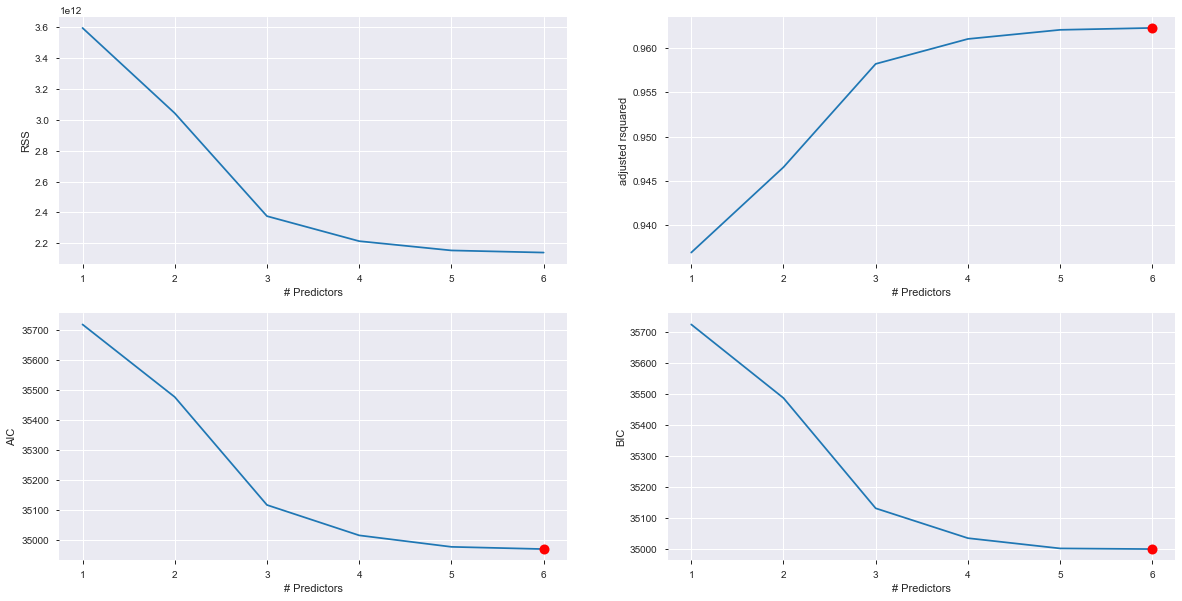

In [43]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# 2x2 grid for 4 plots at once
plt.subplot(2, 2, 1)

# plot red dot for model with the largest adjusted R^2 statistic.
# The argmax() function identifies the maximum vector location
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# plot a red dot to indicate the largest adjusted R^2 model.
# The argmax() function identifies the maximum vector location

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST
#statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

# Ridge Regression

In [44]:
from sklearn.linear_model import Ridge
ridgemodel = Ridge(alpha=10)
ridgemodel.fit(X_train, y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [45]:
y_predictridge = ridgemodel.predict(X_test)

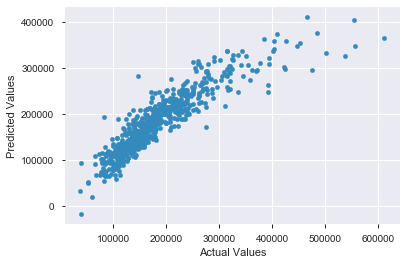

In [46]:
pd.DataFrame({'Actual Values': y_test, 'Predicted Values': y_predictridge}).plot.scatter\
(x='Actual Values', y='Predicted Values')

In [47]:
test_pred_ridge = ridgemodel.predict(X_test)
train_pred_ridge = ridgemodel.predict(X_train)

print('Train Set Ridge Regression : \n')
modelmetrics(y_test, train_pred_ridge)

print('\nTest Set Ridge Regression :')
modelmetrics(y_test,test_pred_ridge)
print("Cross Validation", cross_val(Ridge()))

Train Set Ridge Regression : 

Mean Average Error: 78690.01684465838
Mean Squared Error: 11476220778.893335
Root Mean Squared Error: 107127.1243845056
R2 Square: -0.871678586402725

Test Set Ridge Regression :
Mean Average Error: 21464.729136731614
Mean Squared Error: 1120152398.048443
Root Mean Squared Error: 33468.67786525848
R2 Square: 0.8173122234811949
Cross Validation 0.8006361394865076


Text(0.5, 0, 'y_test')

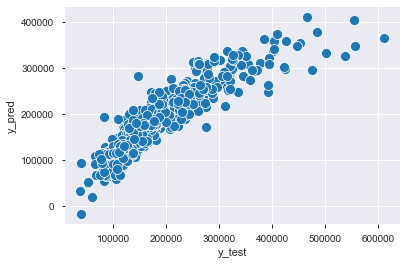

In [48]:
#to test residuals of the ridge regression, appears to be nearly the same as linear regression
test_residual = y_test-y_predictridge
sns.scatterplot(x=y_test, y=y_predictridge)
plt.ylabel('y_pred')
plt.xlabel('y_test')

In [49]:
from sklearn.linear_model import RidgeCV
ridge_cv_model = RidgeCV(alphas =(0.1,1.0,10.0), scoring = 'neg_mean_absolute_error')
ridge_cv_model.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring='neg_mean_absolute_error',
        store_cv_values=False)

In [50]:
y_predictridge = ridge_cv_model.predict(X_test)

In [51]:
# 2* Ridge
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())

Best alpha : 0.6
Try again for more precision with alphas centered around 0.6
Best alpha : 0.84


C:\Users\chris\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\chris\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\chris\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\chris\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: Deprecation

Ridge RMSE on Training set : 39340.06801388995
Ridge RMSE on Test set : 31355.534726862632


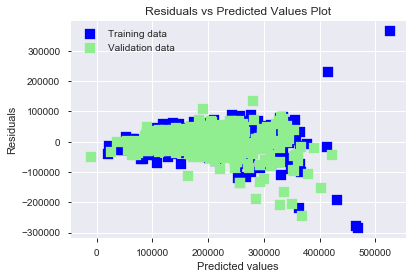

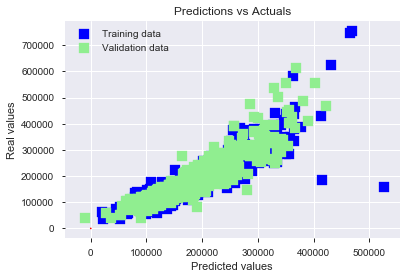

In [52]:
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)
    
#Plot residuals
residuals_plot(y_train_rdg, y_train, y_test_rdg, y_test)

# Plot predictions
predictions_plot(y_train_rdg, y_train, y_test_rdg, y_test)

Ridge picked 35 features and eliminated the other 1 features


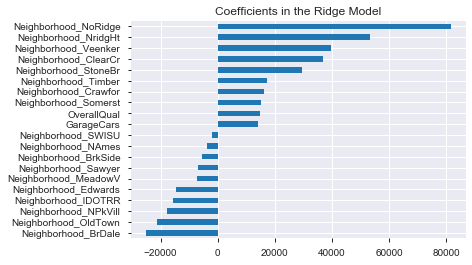

In [53]:
# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

In [54]:
modeltest2 = pd.Series(ridgemodel.predict(finaltestunseen), name = 'SalePrice')

modelsubmission = pd.concat([test['Id'], modeltest2], axis=1)

modelsubmission.to_csv('ridgesubmissionCL.csv', index = False)

# Lasso Regression

In [55]:
#pick out your prediction variables
traincatlas=train[['Neighborhood','SaleCondition']]
trainnumlas=train[['OverallQual','TotalSF','GarageCars','YearBuilt','YearRemodAdd']]

testcatlas=test[['Neighborhood','SaleCondition']]
testnumlas=test[['OverallQual','TotalSF','GarageCars','YearBuilt','YearRemodAdd']]


# create dataframe of dummy variables
catdummieslas = pd.get_dummies(traincatlas, drop_first = True)
catdummiestestlas = pd.get_dummies(testcatlas, drop_first = True)

# Merge numerical and categorical to one dataframe
finaltrainlas = pd.concat([catdummieslas, trainnumlas], axis=1)

#finaltrainlas.drop(columns = ['PoolQC_Fa'], inplace = True)

#for use on unseen test data
finaltestunseenlas = pd.concat([catdummiestestlas, testnumlas], axis=1)

#define input variable (x) and ouput variable y
X=finaltrainlas
y=train['SalePrice']

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .50, random_state = 100)

In [56]:
finaltrainlas.shape

(1460, 34)

In [57]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())

Best alpha : 1.0
Try again for more precision with alphas centered around 1.0
Best alpha : 1.4
Lasso RMSE on Training set : 39400.94180598072
Lasso RMSE on Test set : 31239.718913925364


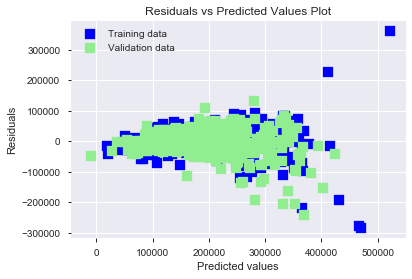

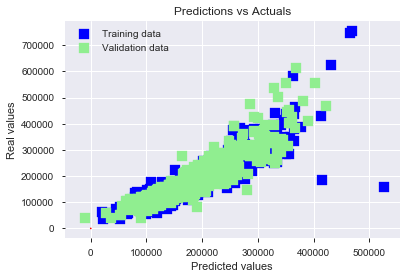

In [58]:
# Plot residuals
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

residuals_plot(y_train_las, y_train, y_test_las,y_test)
predictions_plot(y_train_las, y_train, y_test_las,y_test)

Lasso picked 33 features and eliminated the other 1 features


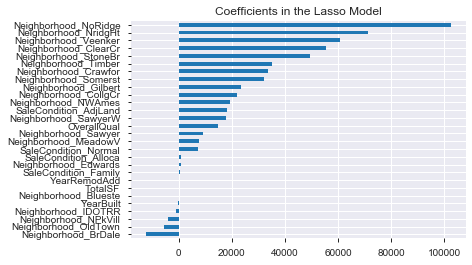

In [59]:
# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(14),
                     coefs.sort_values().tail(14)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

In [60]:
#pd.DataFrame(lasso.coef_, X.columns, columns = ['Coefficient'])

In [61]:
#to identify which feature the Lasso eliminated since columns need to match for Kaggle CSV

list(finaltestunseenlas.columns)

['Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'Neighborhood_Timber',
 'Neighborhood_Veenker',
 'SaleCondition_AdjLand',
 'SaleCondition_Alloca',
 'SaleCondition_Family',
 'SaleCondition_Normal',
 'SaleCondition_Partial',
 'OverallQual',
 'TotalSF',
 'GarageCars',
 'YearBuilt',
 'YearRemodAdd']

In [62]:
list(finaltrainlas.columns)

['Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'Neighborhood_Timber',
 'Neighborhood_Veenker',
 'SaleCondition_AdjLand',
 'SaleCondition_Alloca',
 'SaleCondition_Family',
 'SaleCondition_Normal',
 'SaleCondition_Partial',
 'OverallQual',
 'TotalSF',
 'GarageCars',
 'YearBuilt',
 'YearRemodAdd']

In [63]:
#Kaggle submission Lasso

modeltestlas = pd.Series(lasso.predict(finaltestunseenlas), name = 'SalePrice')

modelsubmission = pd.concat([test['Id'], modeltestlas], axis=1)

modelsubmission.to_csv('lassosubmissionChrisLee.csv', index = False)

# Elastic Net

In [64]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [65]:
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)


Best l1_ratio : 0.3
Best alpha : 0.003
Try again for more precision with l1_ratio centered around 0.3
Best l1_ratio : 0.255
Best alpha : 0.003
Now try again for more precision on alpha, with l1_ratio fixed at 0.255 and alpha centered around 0.003
Best l1_ratio : 0.255
Best alpha : 0.003
ElasticNet RMSE on Training set : 39401.43530187665
ElasticNet RMSE on Test set : 31214.520207933827


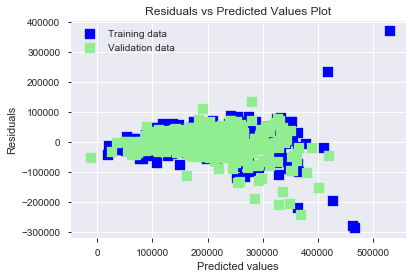

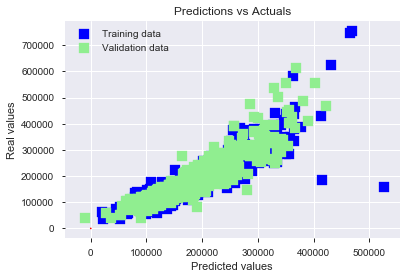

In [66]:
# Plot residuals
residuals_plot(y_train_ela, y_train, y_test_ela,y_test)
#plot predictions
predictions_plot(y_train_ela, y_train, y_test_ela,y_test)

ElasticNet picked 33 features and eliminated the other 1 features


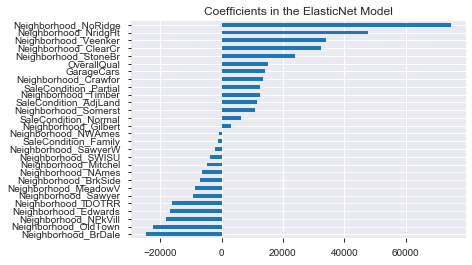

In [67]:
# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(14),
                     coefs.sort_values().tail(14)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()